**DATA DESCRIPTION:**

<p>This The database is basically records of accidents from 12 different plants in 03 different countries which every line in the data is an
occurrence of an accident.</p>


**Columns description:**

‣ **Data**: timestamp or time/date information

‣ **Countries**: which country the accident occurred (anonymised)

‣ **Local**: the city where the manufacturing plant is located (anonymised)

‣ **Industry sector**: which sector the plant belongs to

‣ Accident level: from I to VI, it registers how severe was the accident (I means not severe but VI means very severe)

‣ **Potential Accident Level**: Depending on the Accident Level, the database also registers how severe the accident could have been (due to other factors
involved in the accident)

‣ **Genre**: if the person is male of female

‣ **Employee or Third Party**: if the injured person is an employee or a third party

‣ **Critical Risk**: some description of the risk involved in the accident

‣ **Description**: Detailed description of how the accident happened.

In [1]:
import re
import string
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder

In [2]:
if not nltk:
  !pip install nltk

In [3]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 100)

In [5]:
def mount_drive(fpath):
  try:
    from google.colab import drive
    drive.mount("/content/drive/", force_remount=True)
    google_drive_prefix = "/content/drive/My Drive"
    data_path = f"{google_drive_prefix}/{fpath}"
    print(data_path)
    return data_path
  except ModuleNotFoundError:
    data_prefix = f"{fpath}"

In [6]:
def verify_sample_data(df,records):
  if not(records):
    records = 5
  print(f"verifying first {records} records and last {records} records")

In [7]:
def get_percentage_of_missing_values(df):
  print("Checking for missing values and print percentage for each attribute\n")
  result = (round(df.isnull().sum() / (df.isnull().count())*100))
  print(f"missing value percentage {result}\n")
  return result

In [8]:
def load_and_verify_data(file_path):

    try:
        file_path = mount_drive(file_path)
        data = pd.read_excel(file_path)
        print(f"Rows = {data.shape[0]} and Columns = {data.shape[1]} in the DataFrame\n")
        print(f"{data.info()}\n")
        print(f"{data.describe()}\n")
        return data
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None

In [9]:
def clean_data(df, columns_name_mapping):

    if "Unnamed: 0" in df.columns:
        df.drop("Unnamed: 0", axis=1, inplace=True)
        print("Unnamed: 0 column dropped\n")

    df.rename(columns=columns_name_mapping, inplace=True)

    get_percentage_of_missing_values(df)

    print(f"Duplicate rows sum is: {df.duplicated().sum()} rows\n")
    print("Printing duplicate rows:\n")
    duplicateDF = df[df.duplicated()]
    dup_records = duplicateDF.to_json(orient='records')
    for rec in dup_records.split(','):
        print(rec)

    print("Removing duplicate rows\n")
    df.drop_duplicates(inplace=True)

    print(f"Rows = {df.shape[0]} and Columns = {df.shape[1]} in the DataFrame")
    return df

In [10]:

def plot_distribution(data,variable_name):

  target_variable = data[variable_name]
  plt.hist(target_variable)
  plt.xlabel(f"{variable_name}")
  plt.ylabel("Frequency")
  plt.title("Distribution of Target Variable")
  plt.show()

In [11]:
def plot_tring_accuracy(history,t_lebel,v_level,y_level):

  plt.figure(figsize=(5, 3))
  plt.plot(history.history['accuracy'], color='b', label=t_lebel)
  plt.plot(history.history['val_accuracy'], color='r', label=v_level)
  plt.title(f"{t_lebel} and {v_level}")
  plt.xlabel('Epoch')
  plt.ylabel(y_level)
  plt.legend()
  plt.show()

In [12]:
def identify_outliers(df, column, threshold=1.5):


    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - threshold * iqr
    upper_bound = q3 + threshold * iqr

    print(f"Q1: {q1}\n")
    print(f"Q3: {q3}\n")
    print(f"IQR: {iqr}\n")
    print(f"Lower Bound: {lower_bound}\n")
    print(f"Upper Bound: {upper_bound}\n")

    return (df[column] < lower_bound) | (df[column] > upper_bound)

In [13]:
def get_outliers_details(df):
  for col in df.columns:
    print(f"Outliers for {col}\n")
    if col != 'Description':
      outliers = identify_outliers(df, col, threshold=1.5)
      #print (outliers)

In [14]:
#configs
file_path = "dataset/Data+Set+-+industrial_safety_and_health_database_with_accidents_description.xlsx"

columns_name_mapping ={'Data':'ReportDate',
                      'Countries':'Country',
                      'Genre':'Gender',
                      'Employee or Third Party':'EmployeeType',
                      'Critical Risk':'CriticalRisk'}


# Configure models dictionary
model_config = {
        "LogisticRegression": LogisticRegression(),
        "DecisionTreeClassifier": DecisionTreeClassifier(),
        "RandomForestClassifier": RandomForestClassifier(),
        "SVM": SVC()
    }

#Hyper Parameter
param_grids = {
    'LogisticRegression': {
        'penalty': ['l1', 'l2', 'elasticnet', 'none'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    },
    'DecisionTreeClassifier': {
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'RandomForestClassifier': {
        'n_estimators': [10, 50, 100, 200],
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'SVM': {
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto']
    }
  }


# Define the base models
estimators = [
    ('lr', LogisticRegression()),
    ('rf', RandomForestClassifier()),
    ('svm', SVC())
]

In [15]:
def visualize_dataframe(df):



  # Get descriptive statistics
  descriptive_stats = df.describe()
  print(f"\nDescriptive statistics:\n{descriptive_stats}")

  # Plot distribution of numerical columns
  numerical_cols = df.select_dtypes(include=["int64", "float64"]).columns
  if numerical_cols.size > 0:  # Check if there are any numerical columns
    for col in numerical_cols:
        print(f"Plot distribution of numerical columns: {col}")
        plt.hist(df[col])
        plt.title(f"Distribution of {col}")
        plt.show()
  else:
    print("No numerical columns found for plotting distributions.")

  # Plot bar chart of categorical columns
  for col in df.select_dtypes(include=["object", "category"]):
    print(f"Plot bar chart of categorical columns: {col}")
    counts = df[col].value_counts()
    plt.bar(counts.index, counts.values)
    plt.title(f"Count of values in {col}")
    plt.show()

  # Calculate and plot correlations for numerical columns only if they exist
  if numerical_cols.size > 0:
    correlations = df[numerical_cols].corr()  # Calculate correlations only if numerical columns exist
    sns.heatmap(correlations, annot=True)
    plt.title("Correlation matrix")
    plt.show()
  else:
    print("No numerical columns found for correlation analysis.")

  # Analyze outliers
  for col in df.select_dtypes(include=["int64", "float64"]):
    outliers = identify_outliers(df, col)
    print(f"Outliers for {col}:\n{outliers}")

In [16]:
def preprocess_data(df):
    # Vectorize 'Description'
    vectorizer = TfidfVectorizer()
    if df['Description'].apply(type).eq(list).any():
        df['Description'] = df['Description'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
    X_text = vectorizer.fit_transform(df['Description'])
    # One-hot encode categorical features
    category_cols = [col for col in df.select_dtypes(include=["object", "category"])]
    X_categorical = pd.get_dummies(df[category_cols])
    # Combine features
    X = np.hstack((X_text.toarray(), X_categorical.values))
    y = df['Accident Level']

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test

In [17]:
def apply_smote(X_train, y_train, random_state=42):
    smote = SMOTE(random_state=random_state)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    return X_train_resampled, y_train_resampled

def feature_engineering(df):
    # Create new features based on existing ones
    df['Accident_Severity'] = df['Accident Level'].apply(lambda x: 1 if x in ['I', 'II'] else 2 if x in ['III', 'IV'] else 3)
    df['Industry_Risk'] = df['Industry Sector'].apply(lambda x: 'High' if x == 'Chemical' else 'Medium' if x == 'Oil and Gas' else 'Low')
    df['Employee_Exposure'] = df['EmployeeType'].apply(lambda x: 'High' if x == 'Employee' else 'Low' if x == 'Third Party' else 'Medium')
    return df

def train_ensemble_model(estimators, X_train, y_train, X_test, y_test):
    """
    Trains an ensemble model using the given estimators.

    Args:
        estimators (list of tuples): List of (name, model) pairs.
        X_train (array-like): Training data features.
        y_train (array-like): Training data labels.
        X_test (array-like): Test data features.
        y_test (array-like): Test data labels.

    Returns:
        float: Accuracy of the ensemble model.
        str: Classification report.
    """
    ensemble = VotingClassifier(estimators)
    ensemble.fit(X_train, y_train)
    y_pred = ensemble.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy, classification_report(y_test, y_pred)




def train_ensemble_model(estimators, X_train, y_train, X_test, y_test):
    """
    Trains an ensemble model using the given estimators.

    Args:
        estimators (list of tuples): List of (name, model) pairs.
        X_train (array-like): Training data features.
        y_train (array-like): Training data labels.
        X_test (array-like): Test data features.
        y_test (array-like): Test data labels.

    Returns:
        float: Accuracy of the ensemble model.
        str: Classification report.
    """
    ensemble = VotingClassifier(estimators)
    ensemble.fit(X_train, y_train)
    y_pred = ensemble.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy, classification_report(y_test, y_pred)




def train_and_evaluate_models_hyper_params(model_config, param_grids, X_train, y_train, X_test, y_test):
    """
    Trains and evaluates machine learning models using grid search or random search.

    Args:
        model_config (dict): Dictionary containing model names as keys and model instances as values.
        param_grids (dict): Dictionary containing model names as keys and hyperparameter grids as values.
        X_train (array-like): Training data features.
        y_train (array-like): Training data labels.
        X_test (array-like): Test data features.
        y_test (array-like): Test data labels.

    Returns:
        dict: A dictionary containing best parameters and scores for each model.
    """
    results = {}

    for model_name, param_grid in param_grids.items():
        model = model_config[model_name]

        # Choose the appropriate search method
        search_method = GridSearchCV if model_name != 'SVM' else RandomizedSearchCV

        search = search_method(model, param_grid, cv=5)
        search.fit(X_train, y_train)

        # Store the best parameters and score
        results[model_name] = {
            'best_params': search.best_params_,
            'best_score': search.best_score_
        }

        # Evaluate on test data
        y_pred = search.predict(X_test)
        print(f"\n--- {model_name} ---")
        print("Best parameters:", search.best_params_)
        print("Best score:", search.best_score_)
        print("Classification Report:\n", classification_report(y_test, y_pred))

    return results



import numpy as np
from sklearn.metrics import classification_report

def calculate_total_cost(y_true, y_pred, class_impact):
    """
    Calculates the total cost of misclassification based on a cost matrix.

    Args:
        y_true (array-like): True class labels.
        y_pred (array-like): Predicted class labels.
        class_impact (dict): Dictionary mapping class labels to their business impact.

    Returns:
        float: Total cost of misclassification.
    """
    class_labels = list(class_impact.keys())
    cost_matrix = np.zeros((len(class_impact), len(class_impact)))

    for i, true_class in enumerate(class_impact):
        for j, pred_class in enumerate(class_impact):
            if true_class != pred_class:
                cost_matrix[i, j] = 1

    total_cost = 0
    for i, true_class in enumerate(y_true):
        pred_class = y_pred[i]
        total_cost += cost_matrix[class_labels.index(true_class), class_labels.index(pred_class)]

    return total_cost

def prioritize_high_impact_classes(y_true, y_pred, class_impact, high_impact_classes):
    """
    Prioritizes improving performance for high-impact classes.

    Args:
        y_true (array-like): True class labels.
        y_pred (array-like): Predicted class labels.
        class_impact (dict): Dictionary mapping class labels to their business impact.
        high_impact_classes (list): List of high-impact class labels.

    Returns:
        None
    """
    for c in high_impact_classes:
        misclassified_indices = y_true[(y_true == c) & (y_pred != c)].index.tolist()
        print(f"Misclassified indices for class {c}: {misclassified_indices}")


In [18]:
def calculate_total_cost(y_true, y_pred, class_impact):
    """
    Calculates the total cost of misclassification based on a cost matrix.

    Args:
        y_true (array-like): True class labels.
        y_pred (array-like): Predicted class labels.
        class_impact (dict): Dictionary mapping class labels to their business impact.

    Returns:
        float: Total cost of misclassification.
    """
    class_labels = list(class_impact.keys())
    cost_matrix = np.zeros((len(class_impact), len(class_impact)))

    for i, true_class in enumerate(class_impact):
        for j, pred_class in enumerate(class_impact):
            if true_class != pred_class:
                cost_matrix[i, j] = 1

    total_cost = 0
    for i, true_class in enumerate(y_true):
        pred_class = y_pred[i]
        total_cost += cost_matrix[class_labels.index(true_class), class_labels.index(pred_class)]

    return total_cost

def prioritize_high_impact_classes(y_true, y_pred, class_impact, high_impact_classes):
    """
    Prioritizes improving performance for high-impact classes.

    Args:
        y_true (array-like): True class labels.
        y_pred (array-like): Predicted class labels.
        class_impact (dict): Dictionary mapping class labels to their business impact.
        high_impact_classes (list): List of high-impact class labels.

    Returns:
        None
    """
    for c in high_impact_classes:
        misclassified_indices = y_true[(y_true == c) & (y_pred != c)].index.tolist()
        print(f"Misclassified indices for class {c}: {misclassified_indices}")

def train_and_evaluate_models(model_config,args):
    """

    Args:
      model_config: model configuration
      args: parameters
    """

    # Defining class impact
    class_impact = {
    "I": 1,  # Low impact
    "II": 2,  # Medium impact
    "III": 3,  # High impact
    "IV": 4,  # Severe impact
    "V": 5,  # Catastrophic impact
    }

    # Train and evaluate models with different params
    for name, model in model_config.items():
      print(f"\n--- {name} ---")
      for param_name,args in params.items():

        print(f"\n train and test model parameter {param_name} ---")
        X_train, X_test, y_train, y_test = args

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        print("Accuracy:", accuracy_score(y_test, y_pred))
        print("Classification Report:\n", classification_report(y_test, y_pred))

        # Calculate total cost of misclassification
        total_cost = calculate_total_cost(y_test, y_pred, class_impact)
        print(f"Total cost of misclassification: {total_cost}")

        # Prioritize improving performance for high-impact classes
        high_impact_classes = ["III", "IV", "V"]
        prioritize_high_impact_classes(y_test, y_pred, class_impact, high_impact_classes)

        # Generate the confusion matrix
        confusion_matrix_result = confusion_matrix(y_test, y_pred) # Assign result to variable
        # Print the confusion matrix
        print("Confusion Matrix:\n", confusion_matrix_result)

**Data Ingestion**

In [19]:
data = load_and_verify_data(file_path)

Mounted at /content/drive/
/content/drive/My Drive/dataset/Data+Set+-+industrial_safety_and_health_database_with_accidents_description.xlsx
Rows = 425 and Columns = 11 in the DataFrame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425 entries, 0 to 424
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Unnamed: 0                425 non-null    int64         
 1   Data                      425 non-null    datetime64[ns]
 2   Countries                 425 non-null    object        
 3   Local                     425 non-null    object        
 4   Industry Sector           425 non-null    object        
 5   Accident Level            425 non-null    object        
 6   Potential Accident Level  425 non-null    object        
 7   Genre                     425 non-null    object        
 8   Employee or Third Party   425 non-null    object        
 9   Critical Risk         

In [20]:
df = data.copy()

In [21]:
verify_sample_data(data, 5)

verifying first 5 records and last 5 records


#***Data Summary***

1. **Data and Context**:
   - The dataset contains information related to accidents.
   - Columns include details like date, location, industry sector, accident level, potential accident level, genre, and critical risk.

2. **Key Findings**:
   - The accidents occurred across different countries and localities.
   - Various industry sectors were affected.
   - The severity of accidents ranged from minor to potentially catastrophic.
   - Both employees and third parties were involved.
   - Critical risks were identified.

3. **Limitations**:
   - Further analysis would require examining specific incidents and patterns.


**Data Cleaning**

In [22]:
df = clean_data(df, columns_name_mapping)

Unnamed: 0 column dropped

Checking for missing values and print percentage for each attribute

missing value percentage ReportDate                  0.0
Country                     0.0
Local                       0.0
Industry Sector             0.0
Accident Level              0.0
Potential Accident Level    0.0
Gender                      0.0
EmployeeType                0.0
CriticalRisk                0.0
Description                 0.0
dtype: float64

Duplicate rows sum is: 7 rows

Printing duplicate rows:

[{"ReportDate":1459468800000
"Country":"Country_01"
"Local":"Local_01"
"Industry Sector":"Mining"
"Accident Level":"I"
"Potential Accident Level":"V"
"Gender":"Male"
"EmployeeType":"Third Party (Remote)"
"CriticalRisk":"Others"
"Description":"In circumstances that two workers of the Abratech company were doing putty work inside the conditioning tank (5 meters deep and covered by platforms) of metal gratings - grating- in the upper part)
 two other employees of the HyT company carri

In [23]:
print("Displaying Clean data\n")
verify_sample_data(df,5)

Displaying Clean data

verifying first 5 records and last 5 records


checking unique value

In [24]:
df.nunique(axis=0)

ReportDate                  287
Country                       3
Local                        12
Industry Sector               3
Accident Level                5
Potential Accident Level      6
Gender                        2
EmployeeType                  3
CriticalRisk                 33
Description                 411
dtype: int64

Out of 411 records:

- **ReportDate**: 287 unique values.
- **Country**: 3 unique values.
- **Local**: 12 unique values.
- **Industry Sector**: 3 unique values.
- **Accident Level**: 5 unique values.
- **Potential Accident Level**: 6 unique values.
- **Gender**: 2 unique values.
- **EmployeeType**: 3 unique values.
- **CriticalRisk**: 33 unique values.
- **Description**: 411 unique values.

Chicking missing values

In [25]:
get_percentage_of_missing_values(df)

Checking for missing values and print percentage for each attribute

missing value percentage ReportDate                  0.0
Country                     0.0
Local                       0.0
Industry Sector             0.0
Accident Level              0.0
Potential Accident Level    0.0
Gender                      0.0
EmployeeType                0.0
CriticalRisk                0.0
Description                 0.0
dtype: float64



ReportDate                  0.0
Country                     0.0
Local                       0.0
Industry Sector             0.0
Accident Level              0.0
Potential Accident Level    0.0
Gender                      0.0
EmployeeType                0.0
CriticalRisk                0.0
Description                 0.0
dtype: float64

There is no missing value.

In [26]:
df['ReportDate'] = pd.to_datetime(df['ReportDate'], format='%Y/%m/%d')
df['Accident Level'] = df['Accident Level'].astype('category')
df['Potential Accident Level'] = df['Potential Accident Level'].astype('category')
df['Country'] = df['Country'].astype('category')
df['Local'] = df['Local'].astype('category')
df['Industry Sector'] = df['Industry Sector'].astype('category')
df['Gender'] = df['Gender'].astype('category')
df['EmployeeType'] = df['EmployeeType'].astype('category')
df['CriticalRisk'] = df['CriticalRisk'].astype('category')

df['ReportDate'] = pd.to_datetime(df['ReportDate'])
df['Year'] = df.ReportDate.apply(lambda x : x.year)
df['Month'] = df.ReportDate.apply(lambda x : x.month)
df['Day'] = df.ReportDate.apply(lambda x : x.day)

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 0 to 424
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   ReportDate                418 non-null    datetime64[ns]
 1   Country                   418 non-null    category      
 2   Local                     418 non-null    category      
 3   Industry Sector           418 non-null    category      
 4   Accident Level            418 non-null    category      
 5   Potential Accident Level  418 non-null    category      
 6   Gender                    418 non-null    category      
 7   EmployeeType              418 non-null    category      
 8   CriticalRisk              418 non-null    category      
 9   Description               418 non-null    object        
 10  Year                      418 non-null    int64         
 11  Month                     418 non-null    int64         
 12  Day                       4

,ReportDate,Country,Local,Industry Sector,Accident Level,Potential Accident Level,Gender,EmployeeType,CriticalRisk,Description,Year,Month,Day
0,2016-01-01,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed,While removing the drill rod of the Jumbo 08 f...,2016,1,1
1,2016-01-02,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems,During the activation of a sodium sulphide pum...,2016,1,2
2,2016-01-06,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),Manual Tools,In the sub-station MILPO located at level +170...,2016,1,6
3,2016-01-08,Country_01,Local_04,Mining,I,I,Male,Third Party,Others,Being 9:45 am. approximately in the Nv. 1880 C...,2016,1,8
4,2016-01-10,Country_01,Local_04,Mining,IV,IV,Male,Third Party,Others,Approximately at 11:45 a.m. in circumstances t...,2016,1,10


In [27]:

def preprocess_text(df):


    print("Remove punctuation")
    df['Description'] = df['Description'].astype(str).apply(lambda x: re.sub(r'[^\w\s]', '', x))

    print("Convert text to lowercase")
    df['Description'] = df['Description'].apply(lambda x: x.lower())

    print("Remove stop words")
    stopwords = nltk.corpus.stopwords.words('english')
    df['Description'] = df['Description'].apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords]))

    print("Tokenize the text")
    df['Description'] = df['Description'].apply(nltk.word_tokenize)

    print("Lemmatize the tokens")
    lemmatizer = nltk.stem.WordNetLemmatizer()
    df['Description'] = df['Description'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

    return df

In [28]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Plots training and validation loss, as well as training and validation accuracy.

    Args:
        history: Keras history object containing training history.

    Returns:
        None
    """
    plt.figure(figsize=(12, 4))

    # Plotting training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# NLP Pre-Processing

In [29]:
df = preprocess_text(df)
df.head()

Remove punctuation
Convert text to lowercase
Remove stop words
Tokenize the text
Lemmatize the tokens


,ReportDate,Country,Local,Industry Sector,Accident Level,Potential Accident Level,Gender,EmployeeType,CriticalRisk,Description,Year,Month,Day
0,2016-01-01,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed,"[removing, drill, rod, jumbo, 08, maintenance,...",2016,1,1
1,2016-01-02,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems,"[activation, sodium, sulphide, pump, piping, u...",2016,1,2
2,2016-01-06,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),Manual Tools,"[substation, milpo, located, level, 170, colla...",2016,1,6
3,2016-01-08,Country_01,Local_04,Mining,I,I,Male,Third Party,Others,"[945, approximately, nv, 1880, cx695, ob7, per...",2016,1,8
4,2016-01-10,Country_01,Local_04,Mining,IV,IV,Male,Third Party,Others,"[approximately, 1145, circumstance, mechanic, ...",2016,1,10


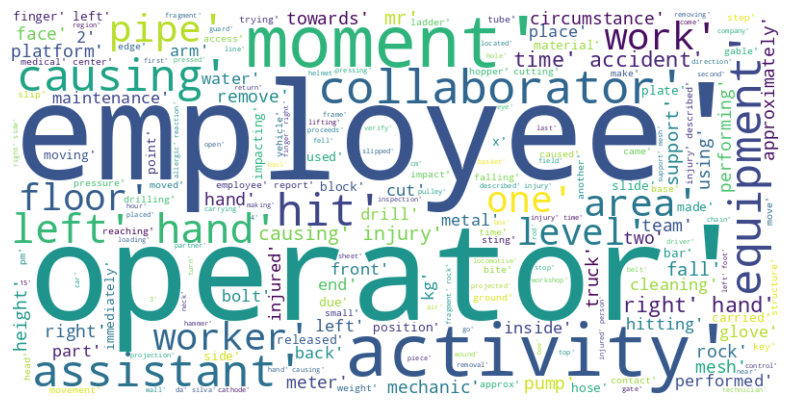

In [30]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Join all descriptions into a single string
all_descriptions = ' '.join(df['Description'].astype(str))

# Create the word cloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_descriptions)

# Display the generated image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [31]:
import numpy as np
import gensim.downloader as api

# Load a pre-trained Word2Vec model
wv = api.load('word2vec-google-news-300')

def get_word2vec_embeddings(text, wv):
  """
  Get Word2Vec embeddings for a given text.
  """
  embeddings = []
  for word in text:
    if word in wv:
      embeddings.append(wv[word])
  if embeddings:
    return np.mean(embeddings, axis=0)
  else:
    return np.zeros(wv.vector_size)


[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [32]:
# Apply Word2Vec embeddings to the 'Description' column
df['word2vec'] = df['Description'].apply(lambda x: get_word2vec_embeddings(x, wv))
df.head()

,ReportDate,Country,Local,Industry Sector,Accident Level,Potential Accident Level,Gender,EmployeeType,CriticalRisk,Description,Year,Month,Day,word2vec
0,2016-01-01,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed,"[removing, drill, rod, jumbo, 08, maintenance,...",2016,1,1,"[-0.06443003, 0.023944236, -0.027033625, 0.077..."
1,2016-01-02,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems,"[activation, sodium, sulphide, pump, piping, u...",2016,1,2,"[-0.06536865, 0.018559208, 0.017885562, 0.0718..."
2,2016-01-06,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),Manual Tools,"[substation, milpo, located, level, 170, colla...",2016,1,6,"[0.0074361167, 0.03296718, -0.012665926, 0.014..."
3,2016-01-08,Country_01,Local_04,Mining,I,I,Male,Third Party,Others,"[945, approximately, nv, 1880, cx695, ob7, per...",2016,1,8,"[0.020122875, 0.021987915, -0.024267023, -0.00..."
4,2016-01-10,Country_01,Local_04,Mining,IV,IV,Male,Third Party,Others,"[approximately, 1145, circumstance, mechanic, ...",2016,1,10,"[-0.017071065, 0.05283923, -0.028414506, 0.009..."


In [33]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

# Load GloVe embeddings
embeddings_index = {}
with open('glove.6B.100d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

def get_glove_embeddings(text, embeddings_index):
    embeddings = []
    for word in text:
        embedding = embeddings_index.get(word)
        if embedding is not None:
            embeddings.append(embedding)
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(len(next(iter(embeddings_index.values()))))

--2024-07-20 05:20:35--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-07-20 05:20:35--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-07-20 05:20:36--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [34]:
# Apply GloVe embeddings to the 'Description' column
df['glove'] = df['Description'].apply(lambda x: get_glove_embeddings(x, embeddings_index))
df.head()

,ReportDate,Country,Local,Industry Sector,Accident Level,Potential Accident Level,Gender,EmployeeType,CriticalRisk,Description,Year,Month,Day,word2vec,glove
0,2016-01-01,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed,"[removing, drill, rod, jumbo, 08, maintenance,...",2016,1,1,"[-0.06443003, 0.023944236, -0.027033625, 0.077...","[-0.1074992, 0.06672626, -0.011156336, -0.1359..."
1,2016-01-02,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems,"[activation, sodium, sulphide, pump, piping, u...",2016,1,2,"[-0.06536865, 0.018559208, 0.017885562, 0.0718...","[-0.26090255, 0.22786835, -0.033934224, 0.0535..."
2,2016-01-06,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),Manual Tools,"[substation, milpo, located, level, 170, colla...",2016,1,6,"[0.0074361167, 0.03296718, -0.012665926, 0.014...","[-0.013339692, 0.11084896, 0.029079314, -0.157..."
3,2016-01-08,Country_01,Local_04,Mining,I,I,Male,Third Party,Others,"[945, approximately, nv, 1880, cx695, ob7, per...",2016,1,8,"[0.020122875, 0.021987915, -0.024267023, -0.00...","[-0.039159816, -0.015952982, 0.06365229, -0.08..."
4,2016-01-10,Country_01,Local_04,Mining,IV,IV,Male,Third Party,Others,"[approximately, 1145, circumstance, mechanic, ...",2016,1,10,"[-0.017071065, 0.05283923, -0.028414506, 0.009...","[-0.056719664, 0.044044573, -0.0015295267, -0...."


In [35]:
y = df['Accident Level']
X = df.drop('Accident Level', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Flatten
from sklearn.preprocessing import LabelEncoder


# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['Accident Level'])
y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Neural Network with Word2Vec Embeddings
model_w2v = Sequential()
model_w2v.add(Dense(128, activation='relu', input_shape=(df['word2vec'].iloc[0].shape[0],)))
model_w2v.add(Dropout(0.2))
model_w2v.add(Dense(len(label_encoder.classes_), activation='softmax'))
model_w2v.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

X_train_w2v = np.stack(df['word2vec'][y_train.index].values)
X_test_w2v = np.stack(df['word2vec'][y_test.index].values)

model_w2v.fit(X_train_w2v, y_train_encoded, epochs=10, validation_data=(X_test_w2v, y_test_encoded))

Epoch 1/10
11/11 [==============================] - 3s 30ms/step - loss: 1.4573 - accuracy: 0.6048 - val_loss: 1.2389 - val_accuracy: 0.7500
Epoch 2/10
11/11 [==============================] - 0s 6ms/step - loss: 1.1192 - accuracy: 0.7365 - val_loss: 0.9479 - val_accuracy: 0.7500
Epoch 3/10
11/11 [==============================] - 0s 5ms/step - loss: 0.9475 - accuracy: 0.7365 - val_loss: 0.8789 - val_accuracy: 0.7500
Epoch 4/10
11/11 [==============================] - 0s 6ms/step - loss: 0.9316 - accuracy: 0.7365 - val_loss: 0.8743 - val_accuracy: 0.7500
Epoch 5/10
11/11 [==============================] - 0s 6ms/step - loss: 0.9135 - accuracy: 0.7365 - val_loss: 0.8701 - val_accuracy: 0.7500
Epoch 6/10
11/11 [==============================] - 0s 6ms/step - loss: 0.8947 - accuracy: 0.7365 - val_loss: 0.8692 - val_accuracy: 0.7500
Epoch 7/10
11/11 [==============================] - 0s 6ms/step - loss: 0.8946 - accuracy: 0.7365 - val_loss: 0.8720 - val_accuracy: 0.7500
Epoch 8/10
11/11 [=

In [37]:
# Neural Network with GloVe Embeddings
model_glove = Sequential()
model_glove.add(Dense(128, activation='relu', input_shape=(df['glove'].iloc[0].shape[0],)))
model_glove.add(Dropout(0.2))
model_glove.add(Dense(len(label_encoder.classes_), activation='softmax'))
model_glove.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

X_train_glove = np.stack(df['glove'][y_train.index].values)
X_test_glove = np.stack(df['glove'][y_test.index].values)

model_glove.fit(X_train_glove, y_train_encoded, epochs=10, validation_data=(X_test_glove, y_test_encoded))

Epoch 1/10
11/11 [==============================] - 1s 19ms/step - loss: 1.4380 - accuracy: 0.3743 - val_loss: 1.1250 - val_accuracy: 0.7500
Epoch 2/10
11/11 [==============================] - 0s 6ms/step - loss: 1.0310 - accuracy: 0.7365 - val_loss: 0.9184 - val_accuracy: 0.7500
Epoch 3/10
11/11 [==============================] - 0s 6ms/step - loss: 0.9326 - accuracy: 0.7365 - val_loss: 0.8999 - val_accuracy: 0.7500
Epoch 4/10
11/11 [==============================] - 0s 6ms/step - loss: 0.9032 - accuracy: 0.7365 - val_loss: 0.8744 - val_accuracy: 0.7500
Epoch 5/10
11/11 [==============================] - 0s 6ms/step - loss: 0.8788 - accuracy: 0.7365 - val_loss: 0.8701 - val_accuracy: 0.7500
Epoch 6/10
11/11 [==============================] - 0s 6ms/step - loss: 0.8677 - accuracy: 0.7365 - val_loss: 0.8673 - val_accuracy: 0.7500
Epoch 7/10
11/11 [==============================] - 0s 6ms/step - loss: 0.8681 - accuracy: 0.7365 - val_loss: 0.8651 - val_accuracy: 0.7500
Epoch 8/10
11/11 [=

In [38]:
# Evaluate Word2Vec model
_, accuracy_w2v = model_w2v.evaluate(X_test_w2v, y_test_encoded)
print('Accuracy Word2Vec: {}'.format(accuracy_w2v))

# Evaluate GloVe model
_, accuracy_glove = model_glove.evaluate(X_test_glove, y_test_encoded)
print('Accuracy GloVe: {}'.format(accuracy_glove))

# Compare accuracies
if accuracy_w2v > accuracy_glove:
    print("Word2Vec model performs better.")
elif accuracy_glove > accuracy_w2v:
    print("GloVe model performs better.")
else:
    print("Both models have the same accuracy.")


3/3 [==============================] - 0s 3ms/step - loss: 0.8572 - accuracy: 0.7500
Accuracy Word2Vec: 0.75
3/3 [==============================] - 0s 4ms/step - loss: 0.8735 - accuracy: 0.7500
Accuracy GloVe: 0.75
Both models have the same accuracy.


In [39]:
from keras.layers import SimpleRNN


all_tokens = [token for sublist in df['Description'] for token in sublist]
unique_tokens = set(all_tokens)
num_unique_tokens = len(unique_tokens)
print(f"Number of unique tokens in the vocabulary: {num_unique_tokens}")

input_length_w2v = df['word2vec'].iloc[0].shape[0]
print("Input length for Word2Vec model:", input_length_w2v)

input_length_glove = df['glove'].iloc[0].shape[0]
print("Input length for GloVe model:", input_length_glove)



vocab_size = num_unique_tokens


embedding_dim = 256

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)


Number of unique tokens in the vocabulary: 3202
Input length for Word2Vec model: 300
Input length for GloVe model: 100


In [40]:
# 1. LSTM with Word Embeddings

# Define the model
model_lstm = Sequential()
model_lstm.add(Embedding(vocab_size, embedding_dim, input_length=input_length_w2v))
model_lstm.add(LSTM(128))
model_lstm.add(Dense(len(label_encoder.classes_), activation='softmax'))

# Compile the model
model_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_lstm = model_lstm.fit(X_train_w2v, y_train_encoded, epochs=10, validation_data=(X_test_w2v, y_test_encoded))

# Evaluate the model
_, accuracy_lstm = model_lstm.evaluate(X_test_w2v, y_test_encoded)
print('Accuracy LSTM: {}'.format(accuracy_lstm))

Epoch 1/10
11/11 [==============================] - 3s 74ms/step - loss: 1.2076 - accuracy: 0.7365 - val_loss: 0.8894 - val_accuracy: 0.7500
Epoch 2/10
11/11 [==============================] - 0s 20ms/step - loss: 0.9195 - accuracy: 0.7365 - val_loss: 0.8972 - val_accuracy: 0.7500
Epoch 3/10
11/11 [==============================] - 0s 16ms/step - loss: 0.9203 - accuracy: 0.7365 - val_loss: 0.9059 - val_accuracy: 0.7500
Epoch 4/10
11/11 [==============================] - 0s 17ms/step - loss: 0.9199 - accuracy: 0.7365 - val_loss: 0.8947 - val_accuracy: 0.7500
Epoch 5/10
11/11 [==============================] - 0s 18ms/step - loss: 0.9200 - accuracy: 0.7365 - val_loss: 0.9011 - val_accuracy: 0.7500
Epoch 6/10
11/11 [==============================] - 0s 18ms/step - loss: 0.9203 - accuracy: 0.7365 - val_loss: 0.8876 - val_accuracy: 0.7500
Epoch 7/10
11/11 [==============================] - 0s 17ms/step - loss: 0.9314 - accuracy: 0.7365 - val_loss: 0.8943 - val_accuracy: 0.7500
Epoch 8/10
11

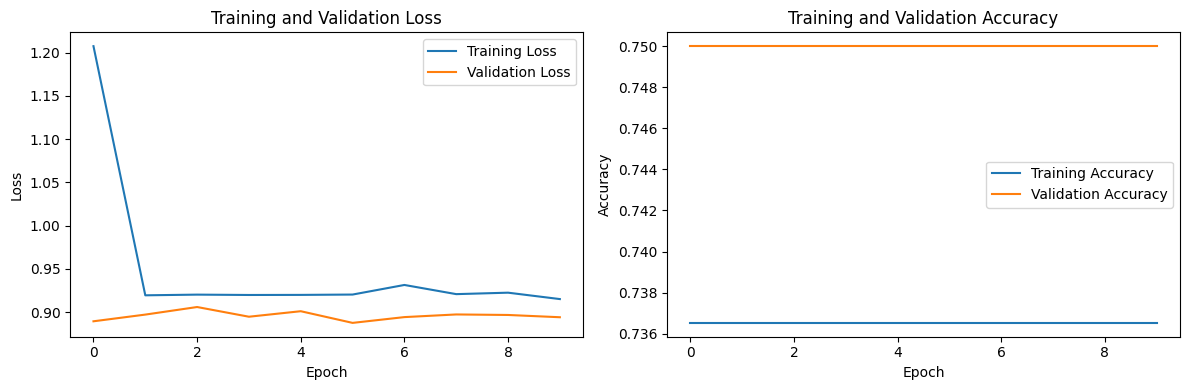

In [41]:
plot_training_history(history_lstm)

In [42]:
# 2. RNN with Word Embeddings (Similar structure to LSTM)

# Define the model
model_rnn = Sequential()
model_rnn.add(Embedding(vocab_size, embedding_dim, input_length=input_length_w2v))
model_rnn.add(SimpleRNN(128))
model_rnn.add(Dense(len(label_encoder.classes_), activation='softmax'))

# Compile the model
model_rnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_rnn = model_rnn.fit(X_train_w2v, y_train_encoded, epochs=10, validation_data=(X_test_w2v, y_test_encoded))

# Evaluate the model
_, accuracy_rnn = model_rnn.evaluate(X_test_w2v, y_test_encoded)
print('Accuracy RNN: {}'.format(accuracy_rnn))


Epoch 1/10
11/11 [==============================] - 4s 202ms/step - loss: 1.0596 - accuracy: 0.6737 - val_loss: 0.8949 - val_accuracy: 0.7500
Epoch 2/10
11/11 [==============================] - 2s 184ms/step - loss: 0.9525 - accuracy: 0.7365 - val_loss: 0.9220 - val_accuracy: 0.7500
Epoch 3/10
11/11 [==============================] - 2s 190ms/step - loss: 0.9276 - accuracy: 0.7365 - val_loss: 0.8854 - val_accuracy: 0.7500
Epoch 4/10
11/11 [==============================] - 2s 196ms/step - loss: 0.9289 - accuracy: 0.7365 - val_loss: 0.8951 - val_accuracy: 0.7500
Epoch 5/10
11/11 [==============================] - 2s 205ms/step - loss: 0.9194 - accuracy: 0.7365 - val_loss: 0.8951 - val_accuracy: 0.7500
Epoch 6/10
11/11 [==============================] - 2s 205ms/step - loss: 0.9153 - accuracy: 0.7365 - val_loss: 0.8975 - val_accuracy: 0.7500
Epoch 7/10
11/11 [==============================] - 2s 200ms/step - loss: 0.9158 - accuracy: 0.7365 - val_loss: 0.8878 - val_accuracy: 0.7500
Epoch 

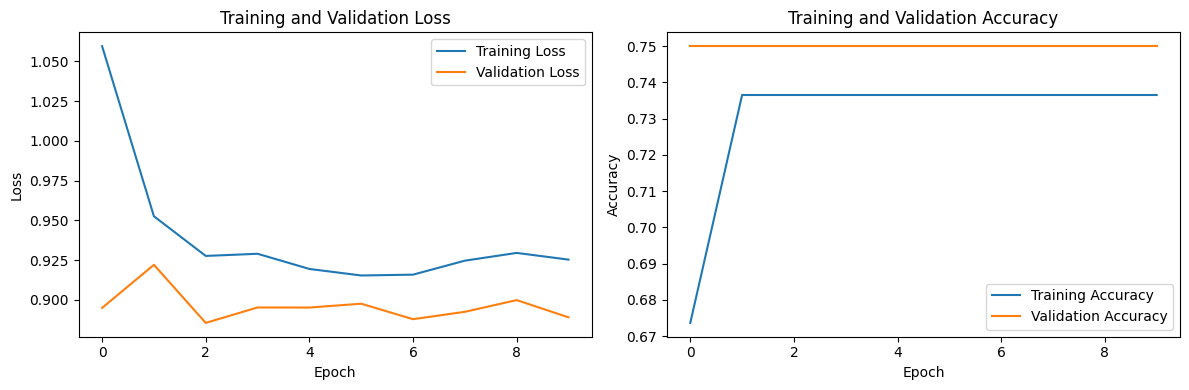

In [43]:
plot_training_history(history_rnn)

In [44]:
!pip install transformers

In [46]:
import numpy as np

from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

# Load pre-trained BERT tokenizer and model
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = TFBertForSequenceClassification.from_pretrained(model_name, num_labels=len(df['Accident Level'].unique()))

# Prepare data for BERT
def convert_data_to_examples(df, label_column):
    InputExamples = []
    for index, row in df.iterrows():
        text_a = row['Description']  # Use the preprocessed 'Description' column
        label = row[label_column]
        InputExamples.append(InputExample(guid=index, text_a=text_a, text_b=None, label=label))
    return InputExamples

def convert_examples_to_features(examples, tokenizer, max_length):
    features = []
    for example in examples:
        inputs = tokenizer.encode_plus(
            example.text_a,
            add_special_tokens=True,
            max_length=max_length,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_token_type_ids=True,
            truncation=True
        )
        features.append(
            InputFeatures(
                input_ids=inputs['input_ids'],
                attention_mask=inputs['attention_mask'],
                token_type_ids=inputs['token_type_ids'],
                label=example.label
            )
        )
    return features

# Convert data to BERT input format
train_examples = convert_data_to_examples(df, 'Accident Level')
train_features = convert_examples_to_features(train_examples, tokenizer, max_length=128)  # Adjust max_length as needed

# Extract input features for training
train_input_ids = np.array([f.input_ids for f in train_features])
train_attention_masks = np.array([f.attention_mask for f in train_features])
train_token_type_ids = np.array([f.token_type_ids for f in train_features])
# Extract labels from the training examples
train_labels = [example.label for example in train_examples]  # Extract the actual labels

label_map = {'I': 0, 'II': 1, 'III': 2, 'IV': 3, 'V': 4}  # Map string labels to integers
train_labels_encoded = np.array([label_map[label] for label in train_labels])  # Now use the extracted labels


# Compile and train the BERT model
optimizer = 'adam'  # Use the string identifier for the Adam optimizer
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

history_bert = model.fit(
    [train_input_ids, train_attention_masks, train_token_type_ids],
    train_labels_encoded,  # Use integer labels
    epochs=3,
    batch_size=16
)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
27/27 [==============================] - 87s 384ms/step - loss: 1.1270 - accuracy: 0.5824
Epoch 2/3
27/27 [==============================] - 10s 387ms/step - loss: 0.9842 - accuracy: 0.6995
Epoch 3/3
27/27 [==============================] - 10s 389ms/step - loss: 0.9537 - accuracy: 0.7207


In [53]:
# Evaluate models and store results
results = {
    "Word2Vec": accuracy_w2v,
    "GloVe": accuracy_glove,
    "LSTM": accuracy_lstm,
    "RNN": accuracy_rnn,
    "BERT": history_bert.history['accuracy'][-1]  # Get final accuracy from BERT training
}

# Print and compare results
for model_name, accuracy in results.items():
    print(f"{model_name} Accuracy: {accuracy:.4f}")

# Find the best performing model
best_model = max(results, key=results.get)
print(f"\nBest Performing Model: {best_model} with accuracy {results[best_model]:.4f}")


Word2Vec Accuracy: 0.7500
GloVe Accuracy: 0.7500
LSTM Accuracy: 0.7500
RNN Accuracy: 0.7500
BERT Accuracy: 0.7207

Best Performing Model: Word2Vec with accuracy 0.7500


In [54]:
import pickle

best_model = model_w2v


filename = 'best_accident_classifier.pkl'
pickle.dump(best_model, open(filename, 'wb'))


# chatbot

In [57]:
import pickle
import numpy as np
import nltk
from nltk.stem import WordNetLemmatizer
import gensim.downloader as api
import re
from sklearn.preprocessing import LabelEncoder
import tkinter as tk
from tkinter import simpledialog

filename = 'best_accident_classifier.pkl'  # Update with your actual filename
loaded_model = pickle.load(open(filename, 'rb'))

wv = api.load('word2vec-google-news-300')

# Preprocess user input
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    stopwords = nltk.corpus.stopwords.words('english')
    text = ' '.join([word for word in text.split() if word not in stopwords])
    tokens = nltk.word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(word) for word in tokens]
    return lemmas

# Get Word2Vec embeddings
def get_word2vec_embeddings(text, wv):
    embeddings = []
    for word in text:
        if word in wv:
            embeddings.append(wv[word])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(wv.vector_size)

# Function to predict accident level
def predict_accident_level(user_input):
    # Preprocess user input
    preprocessed_input = preprocess_text(user_input)

    # Get Word2Vec embeddings
    input_embeddings = get_word2vec_embeddings(preprocessed_input, wv)
    input_embeddings = input_embeddings.reshape(1, -1)  # Reshape for model input

    # Predict accident level
    prediction = loaded_model.predict(input_embeddings)
    predicted_class = np.argmax(prediction)

    # Map predicted class back to original labels
    label_encoder = LabelEncoder()  # Assuming you used LabelEncoder during training
    label_encoder.fit(['I', 'II', 'III', 'IV', 'V'])  # Replace with your actual labels
    predicted_label = label_encoder.inverse_transform([predicted_class])[0]

    return predicted_label

In [63]:
# chatbot UI
def chatbot_ui():
    while True:
        user_input = input("Accident Classifier - Describe the accident (or type 'quit' to exit): ")
        if user_input.lower() == 'quit':
            break

        predicted_label = predict_accident_level(user_input)
        print(f"Predicted Accident Level: {predicted_label}")

chatbot_ui()

Accident Classifier - Describe the accident (or type 'quit' to exit): Team of the VMS Project performed soil collection on the Xix\u00e1s target with 3 members. When the teams were moving from one collection point to another  Mr. Fabio was ahead of the team  stinging behind Robson and Manoel da Silva. near the collection point were surprised by a swarm of bees that was inside a I play near the ground  with no visibility in the woods and no hissing noise. Fabio passed by the stump  but Robson and Manoel da Silva were attacked by the bees. Robson had a sting in his left arm over his uniform and Manoel da Silva had a prick in his lip as his screen ripped as he tangled in the branches during the escape
1/1 [==============================] - 0s 19ms/step
Predicted Accident Level: I
Accident Classifier - Describe the accident (or type 'quit' to exit): fire on home
1/1 [==============================] - 0s 18ms/step
Predicted Accident Level: II
Accident Classifier - Describe the accident (or 

In [ ]:
#from google.colab import files
#files.download('best_accident_classifier.pkl')
